In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=cefb83f77af50bff596cb451bf4b0de5f01f0bbf455ce175b005097dde830abb
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
#Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, to_timestamp, count, mean, stddev, min, max, year, month, sum as sum_, hour
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
import pandas as pd

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/Motor_Vehicle.csv"
# Initialize Spark session
spark = SparkSession.builder.appName("MotorVehicleCollisionsAnalysis").getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
df = (df.withColumn('DATE_YEAR', year(to_date('CRASH DATE', 'MM/dd/yyyy')))
        .withColumn('DATE_MTH', month(to_date('CRASH DATE', 'MM/dd/yyyy'))))
df  = df.filter(col('DATE_YEAR') == 2022)

# Show the first few rows of the filtered DataFrame
df.show(5)

+----------+----------+--------+--------+---------+---------+--------------------+--------------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+--------------------+-------------------+-------------------+-------------------+---------+--------+
|CRASH DATE|CRASH TIME| BOROUGH|ZIP CODE| LATITUDE|LONGITUDE|            LOCATION|      ON STREET NAME|CROSS STREET NAME|     OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONT

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 103880
Number of Columns: 31


**Data Wrangling**

In [ ]:
#Display column names
df.columns

['CRASH DATE',
 'CRASH TIME',
 'BOROUGH',
 'ZIP CODE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'ON STREET NAME',
 'CROSS STREET NAME',
 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED',
 'NUMBER OF CYCLIST KILLED',
 'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'COLLISION_ID',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5',
 'DATE_YEAR',
 'DATE_MTH']

In [ ]:
#5-point summary for attributes
df.describe().show()

+-------+----------+----------+-------------+------------------+------------------+------------------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-----------------+
|summary|CRASH DATE|CRASH TIME|      BOROUGH|          ZIP CODE|          LATITUDE|         LONGITUDE|            LOCATION|ON STREET NAME|CROSS STREET NAME|     OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURE

In [ ]:
#Counting null values in each column
null_counts = df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+----------+----------+-------+--------+--------+---------+--------+--------------+-----------------+---------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+--------+
|CRASH DATE|CRASH TIME|BOROUGH|ZIP CODE|LATITUDE|LONGITUDE|LOCATION|ON STREET NAME|CROSS STREET NAME|OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR VEHICLE 1|CONTRIBUTING FACTOR VEHIC

In [ ]:
#Removing null-values records from the dataset
columns_to_check = [
    'BOROUGH',
    'LOCATION',
    'ZIP CODE',
    "NUMBER OF PERSONS INJURED",
    "NUMBER OF PERSONS KILLED",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "NUMBER OF MOTORIST INJURED",
    "NUMBER OF MOTORIST KILLED"
]

# Drop rows with null values in specified columns
df = df.dropna(subset=columns_to_check)

In [ ]:
#Check datatypes for each column in data
for col_name, col_type in df.dtypes:
    print(f"Column '{col_name}' has data type: {col_type}")

Column 'CRASH DATE' has data type: string
Column 'CRASH TIME' has data type: string
Column 'BOROUGH' has data type: string
Column 'ZIP CODE' has data type: string
Column 'LATITUDE' has data type: double
Column 'LONGITUDE' has data type: double
Column 'LOCATION' has data type: string
Column 'ON STREET NAME' has data type: string
Column 'CROSS STREET NAME' has data type: string
Column 'OFF STREET NAME' has data type: string
Column 'NUMBER OF PERSONS INJURED' has data type: string
Column 'NUMBER OF PERSONS KILLED' has data type: int
Column 'NUMBER OF PEDESTRIANS INJURED' has data type: int
Column 'NUMBER OF PEDESTRIANS KILLED' has data type: int
Column 'NUMBER OF CYCLIST INJURED' has data type: int
Column 'NUMBER OF CYCLIST KILLED' has data type: string
Column 'NUMBER OF MOTORIST INJURED' has data type: string
Column 'NUMBER OF MOTORIST KILLED' has data type: int
Column 'CONTRIBUTING FACTOR VEHICLE 1' has data type: string
Column 'CONTRIBUTING FACTOR VEHICLE 2' has data type: string
Colum

In [ ]:
#Removing duplicate records from the dataset
df = df.dropDuplicates()

#Changing datatypes of relevant features
columns_to_cast = ["ZIP CODE", "NUMBER OF PERSONS INJURED", "NUMBER OF CYCLIST KILLED", "NUMBER OF MOTORIST INJURED"]

df = df.select(*[col(c).cast("integer").alias(c) if c in columns_to_cast else col(c) for c in df.columns])

In [ ]:
#Check datatypes for each column in data
for col_name, col_type in df.dtypes:
    print(f"Column '{col_name}' has data type: {col_type}")

Column 'CRASH DATE' has data type: string
Column 'CRASH TIME' has data type: string
Column 'BOROUGH' has data type: string
Column 'ZIP CODE' has data type: int
Column 'LATITUDE' has data type: double
Column 'LONGITUDE' has data type: double
Column 'LOCATION' has data type: string
Column 'ON STREET NAME' has data type: string
Column 'CROSS STREET NAME' has data type: string
Column 'OFF STREET NAME' has data type: string
Column 'NUMBER OF PERSONS INJURED' has data type: int
Column 'NUMBER OF PERSONS KILLED' has data type: int
Column 'NUMBER OF PEDESTRIANS INJURED' has data type: int
Column 'NUMBER OF PEDESTRIANS KILLED' has data type: int
Column 'NUMBER OF CYCLIST INJURED' has data type: int
Column 'NUMBER OF CYCLIST KILLED' has data type: int
Column 'NUMBER OF MOTORIST INJURED' has data type: int
Column 'NUMBER OF MOTORIST KILLED' has data type: int
Column 'CONTRIBUTING FACTOR VEHICLE 1' has data type: string
Column 'CONTRIBUTING FACTOR VEHICLE 2' has data type: string
Column 'CONTRIBUT

In [ ]:
def freq(df, var):
    # Get frequency table for the specified variable
    tmp_freq = df.groupBy(var).count()

    return tmp_freq
freq_result = freq(df, 'NUMBER OF PERSONS KILLED')
freq_result.show()

+------------------------+-----+
|NUMBER OF PERSONS KILLED|count|
+------------------------+-----+
|                       1|  132|
|                       2|    2|
|                       0|66501|
|                       3|    1|
+------------------------+-----+



In [ ]:
# Renaming Columns
df = (df.withColumnRenamed('ZIP CODE', 'ZIP_CODE')
        .withColumnRenamed('ON STREET NAME', 'STREET_ON')
        .withColumnRenamed('CROSS STREET NAME', 'STREET_CROSS')
        .withColumnRenamed('OFF STREET NAME', 'STREET_OFF')
        .withColumnRenamed('NUMBER OF PERSONS INJURED', 'NUM_PER_INJUR')
        .withColumnRenamed('NUMBER OF PERSONS KILLED', 'NUM_PER_KILL')
        .withColumnRenamed('NUMBER OF PEDESTRIANS INJURED', 'NUM_PED_INJUR')
        .withColumnRenamed('NUMBER OF PEDESTRIANS KILLED', 'NUM_PED_KILL')
        .withColumnRenamed('NUMBER OF CYCLIST INJURED', 'NUM_CYC_INJUR')
        .withColumnRenamed('NUMBER OF CYCLIST KILLED', 'NUM_CYC_KILL')
        .withColumnRenamed('NUMBER OF MOTORIST INJURED', 'NUM_MOTOR_INJUR')
        .withColumnRenamed('NUMBER OF MOTORIST KILLED', 'NUM_MOTOR_KILL')
        .withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 1', 'VEH_FACTOR_1')
        .withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 2', 'VEH_FACTOR_2')
        .withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 3', 'VEH_FACTOR_3')
        .withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 4', 'VEH_FACTOR_4')
        .withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 5', 'VEH_FACTOR_5')
        .withColumnRenamed('UNIQUE KEY', 'UNIQUE_KEY')
        .withColumnRenamed('VEHICLE TYPE CODE 1', 'VEH_TYPE_1')
        .withColumnRenamed('VEHICLE TYPE CODE 2', 'VEH_TYPE_2')
        .withColumnRenamed('VEHICLE TYPE CODE 3', 'VEH_TYPE_3')
        .withColumnRenamed('VEHICLE TYPE CODE 4', 'VEH_TYPE_4')
        .withColumnRenamed('VEHICLE TYPE CODE 5', 'VEH_TYPE_5'))


# Create Time Variable to O'Clock Format
time_dict = {'0': 'A 0 O Clock', '1': 'B 1 O Clock', '2': 'C 2 O Clock',
             '3': 'D 3 O Clock', '4': 'E 4 O Clock', '5': 'F 5 O Clock',
             '6': 'G 6 O Clock', '7': 'H 7 O Clock', '8': 'I 8 O Clock',
             '9': 'J 9 O Clock', '10': 'K 10 O Clock', '11': 'L 11 O Clock',
             '12': 'M 12 O Clock', '13': 'N 13 O Clock', '14': 'O 14 Clock',
             '15': 'P 15 O Clock', '16': 'Q 16 O Clock', '17': 'R 17 O Clock',
             '18': 'S 18 O Clock', '19': 'T 19 O Clock', '20': 'U 20 O Clock',
             '21': 'V 21 O Clock', '22': 'W 22 O Clock', '23': 'X 23 O Clock'}

# Map Time to O'Clock Format
df = df.withColumn('TIME_O', col('CRASH TIME').substr(0, 2))
df = df.replace(time_dict, 1, 'TIME_O')

# Clean Up NA Values
df = df.fillna({'NUM_PER_INJUR': 0, 'NUM_PER_KILL': 0})

# View Updated Schema
df.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- STREET_ON: string (nullable = true)
 |-- STREET_CROSS: string (nullable = true)
 |-- STREET_OFF: string (nullable = true)
 |-- NUM_PER_INJUR: integer (nullable = false)
 |-- NUM_PER_KILL: integer (nullable = false)
 |-- NUM_PED_INJUR: integer (nullable = true)
 |-- NUM_PED_KILL: integer (nullable = true)
 |-- NUM_CYC_INJUR: integer (nullable = true)
 |-- NUM_CYC_KILL: integer (nullable = true)
 |-- NUM_MOTOR_INJUR: integer (nullable = true)
 |-- NUM_MOTOR_KILL: integer (nullable = true)
 |-- VEH_FACTOR_1: string (nullable = true)
 |-- VEH_FACTOR_2: string (nullable = true)
 |-- VEH_FACTOR_3: string (nullable = true)
 |-- VEH_FACTOR_4: string (nullable = true)
 |-- VEH_FACTOR_5: string (nullable =

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:4667: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [ ]:
num_rows = df.count()
num_cols = len(df.columns)

#Shape of the dataset after pre-processing
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 66636
Number of columns: 32


**Exploratory Data Analysis(EDA)**

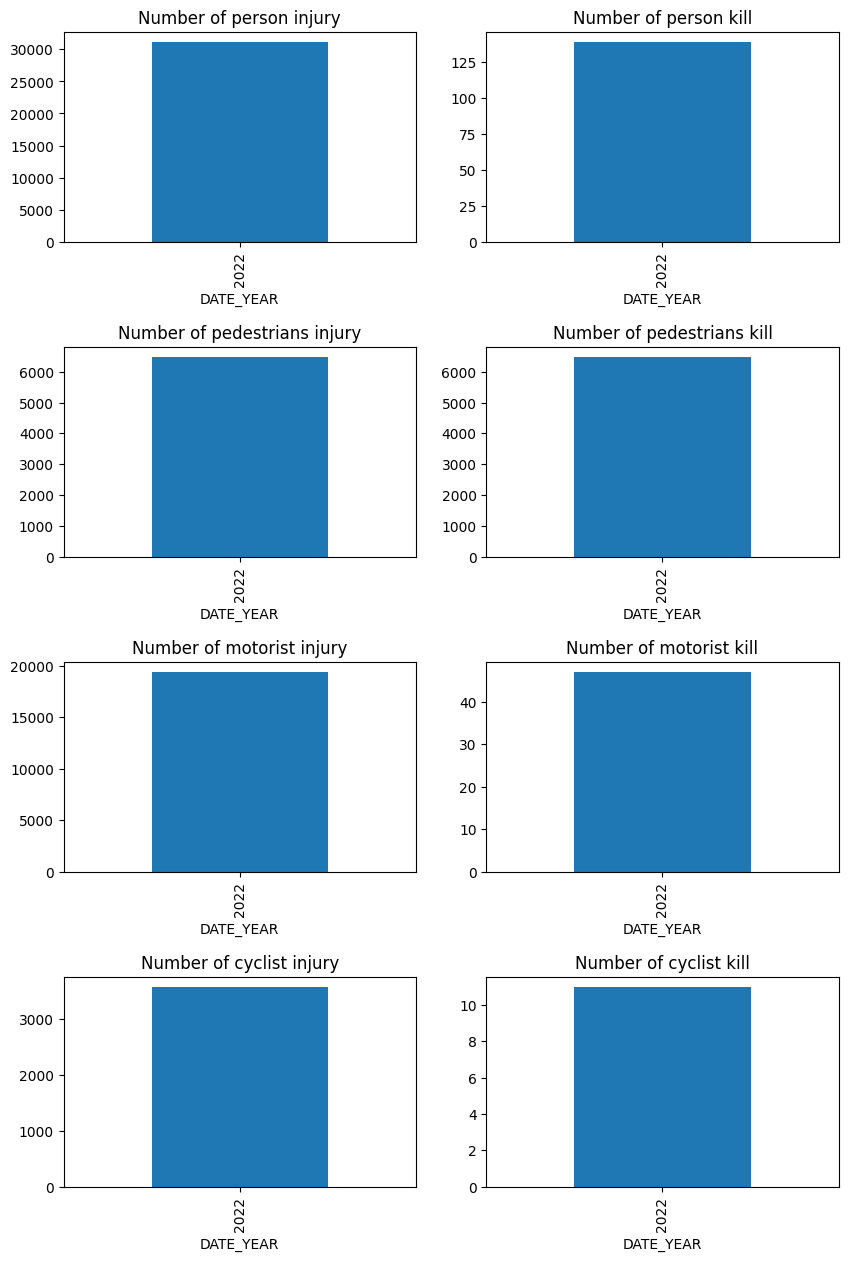

In [ ]:
# Convert to Pandas DataFrame for plotting
pandas_df = df.toPandas()

plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

# Looking at frequency of person injury by year
plt.subplot(4, 2, 1)
pandas_df.groupby('DATE_YEAR')['NUM_PER_INJUR'].sum().plot(kind='bar')
plt.title('Number of person injury')

# Looking at frequency of person kill by year
plt.subplot(4, 2, 2)
pandas_df.groupby('DATE_YEAR')['NUM_PER_KILL'].sum().plot(kind='bar')
plt.title('Number of person kill')

# Looking at frequency of PEDESTRIANS injury by year
plt.subplot(4, 2, 3)
pandas_df.groupby('DATE_YEAR')['NUM_PED_INJUR'].sum().plot(kind='bar')
plt.title('Number of pedestrians injury')

# Looking at frequency of pedesstrians kill by year
plt.subplot(4, 2, 4)
pandas_df.groupby('DATE_YEAR')['NUM_PED_INJUR'].sum().plot(kind='bar')
plt.title('Number of pedestrians kill')

# Looking at frequency of pedestrians kill by year
plt.subplot(4, 2, 5)
pandas_df.groupby('DATE_YEAR')['NUM_MOTOR_INJUR'].sum().plot(kind='bar')
plt.title('Number of motorist injury')

# Looking at frequency of pedestrians kill by year
plt.subplot(4, 2, 6)
pandas_df.groupby('DATE_YEAR')['NUM_MOTOR_KILL'].sum().plot(kind='bar')
plt.title('Number of motorist kill')

# Looking at frequency of pedesstrians kill by year
plt.subplot(4, 2, 7)
pandas_df.groupby('DATE_YEAR')['NUM_CYC_INJUR'].sum().plot(kind='bar')
plt.title('Number of cyclist injury')

# Looking at frequency of pedesstrians kill by year
plt.subplot(4, 2, 8)
pandas_df.groupby('DATE_YEAR')['NUM_CYC_KILL'].sum().plot(kind='bar')
plt.title('Number of cyclist kill')
plt.show()

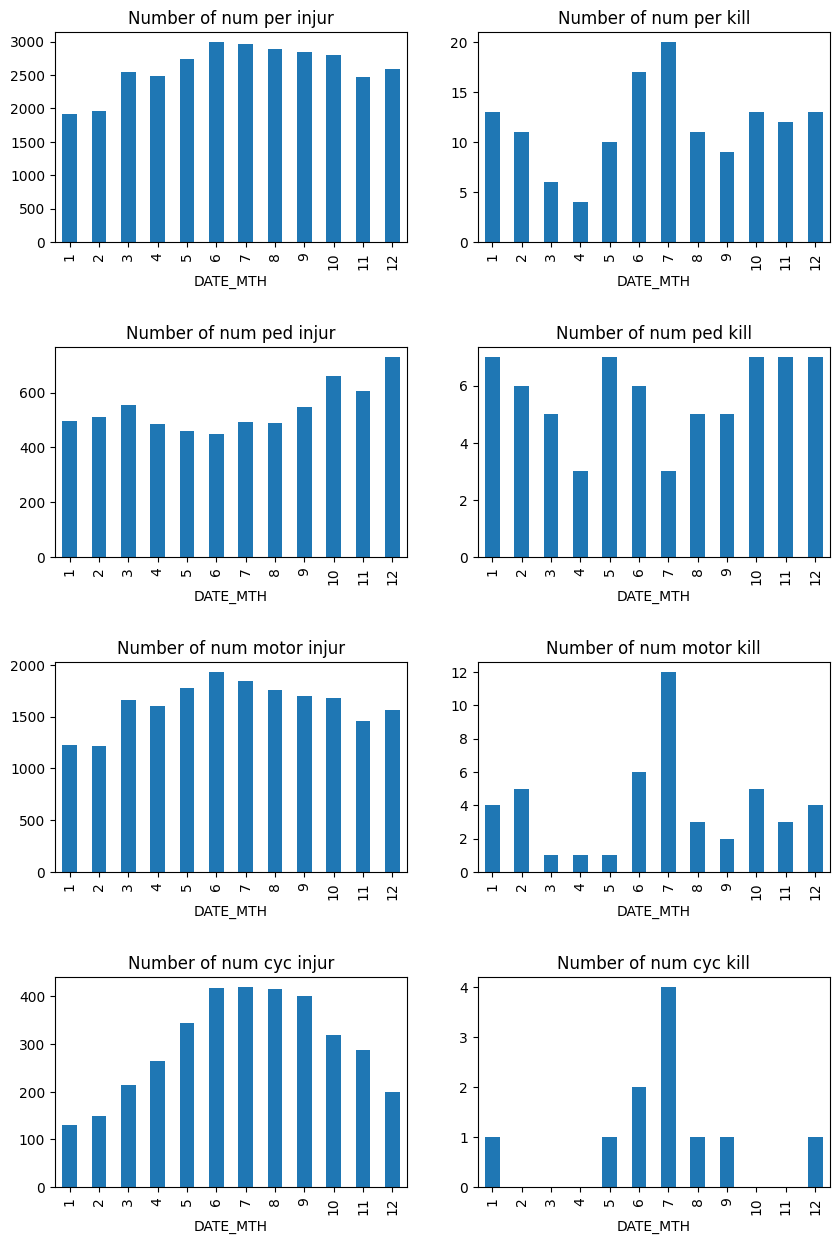

In [ ]:
# Set subplot size and space
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

# Define the injury categories
injury_categories = ['NUM_PER_INJUR', 'NUM_PER_KILL', 'NUM_PED_INJUR', 'NUM_PED_KILL',
                      'NUM_MOTOR_INJUR', 'NUM_MOTOR_KILL', 'NUM_CYC_INJUR', 'NUM_CYC_KILL']

# Create bar plots for each injury category by month
for i, category in enumerate(injury_categories, 1):
    plt.subplot(4, 2, i)
    pandas_df.groupby('DATE_MTH')[category].sum().plot(kind='bar')
    plt.title(f'Number of {category.lower().replace("_", " ")}')
plt.show()

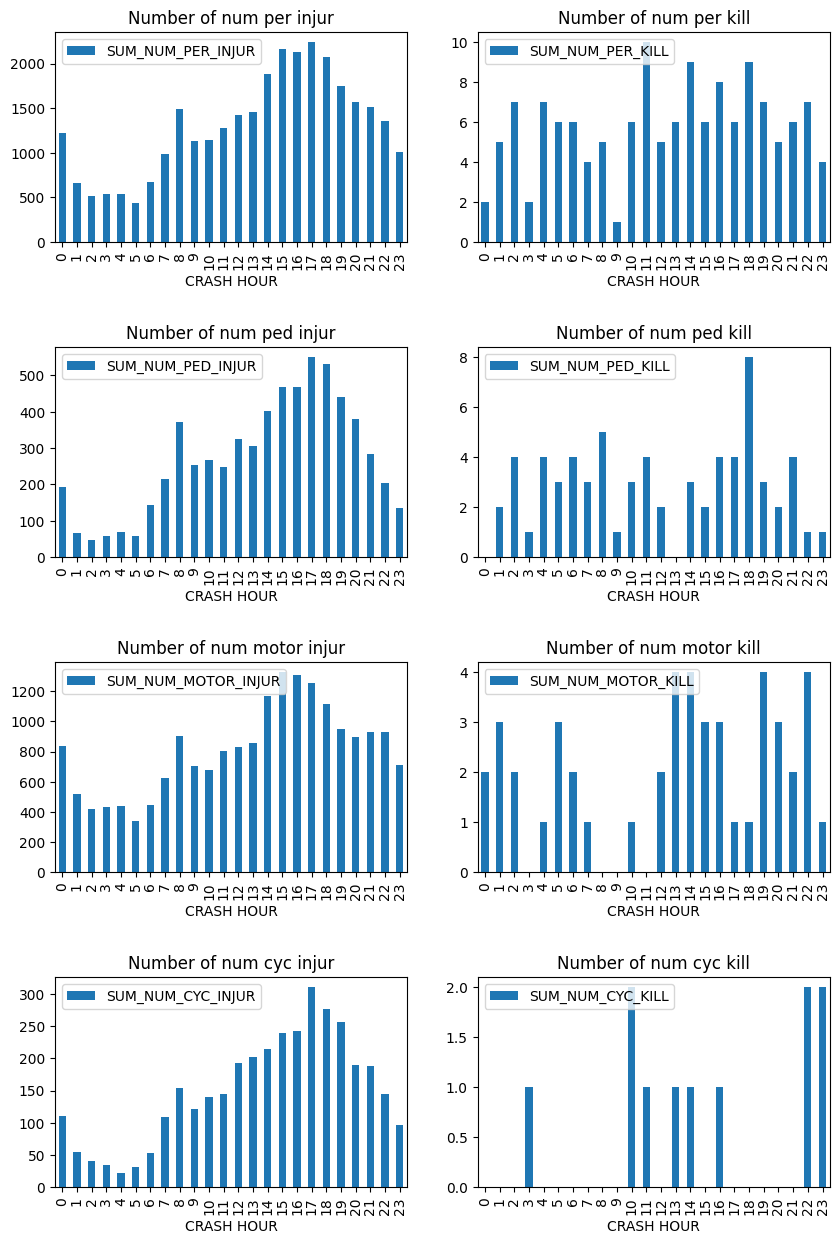

In [ ]:
#Set subplot size and space
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

# Define the injury categories
injury_categories = ['NUM_PER_INJUR', 'NUM_PER_KILL', 'NUM_PED_INJUR', 'NUM_PED_KILL',
                      'NUM_MOTOR_INJUR', 'NUM_MOTOR_KILL', 'NUM_CYC_INJUR', 'NUM_CYC_KILL']

# Create bar plots for each injury category by time group
for i, category in enumerate(injury_categories, 1):
    plt.subplot(4, 2, i)
    category_sum_df = df.groupBy(hour('CRASH TIME').alias('CRASH HOUR')) \
                        .agg(sum(col(category)).alias('SUM_' + category)) \
                        .orderBy('CRASH HOUR') \
                        .toPandas()
    category_sum_df.plot.bar(x='CRASH HOUR', y='SUM_' + category, ax=plt.gca())
    plt.title(f'Number of {category.lower().replace("_", " ")}')

# Show the bar plots
plt.show()

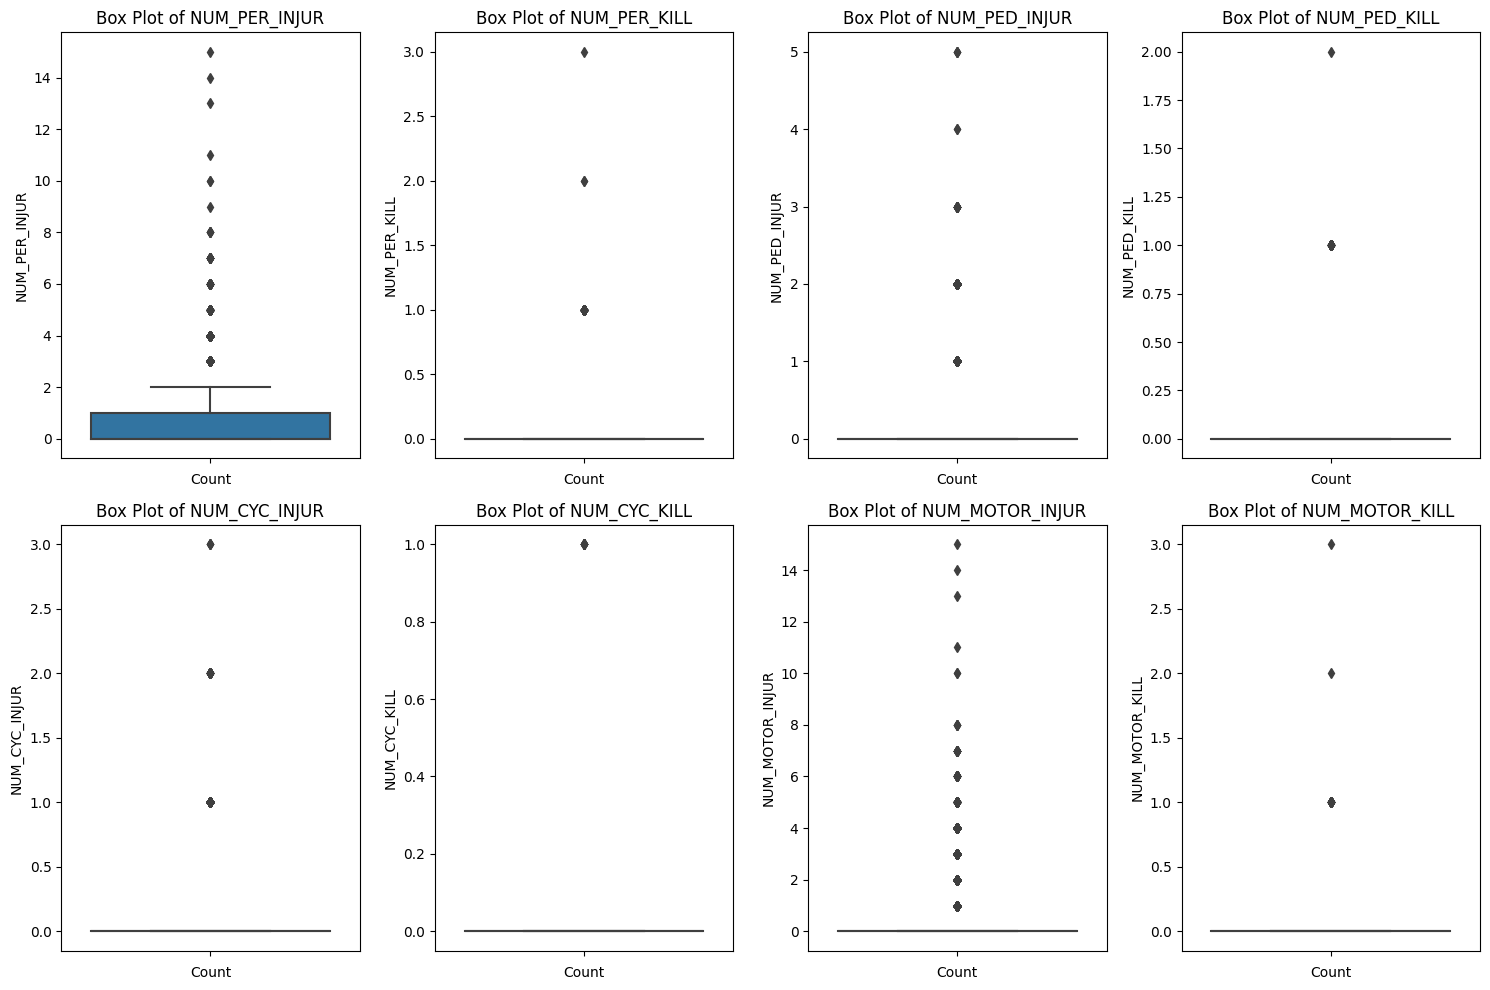

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the selected columns of PySpark DataFrame to Pandas DataFrame
pdf = df.select("NUM_PER_INJUR", "NUM_PER_KILL", "NUM_PED_INJUR",
                "NUM_PED_KILL", "NUM_CYC_INJUR", "NUM_CYC_KILL",
                "NUM_MOTOR_INJUR", "NUM_MOTOR_KILL").toPandas()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# List of columns to plot
columns_to_plot = ["NUM_PER_INJUR", "NUM_PER_KILL", "NUM_PED_INJUR",
                   "NUM_PED_KILL", "NUM_CYC_INJUR", "NUM_CYC_KILL",
                   "NUM_MOTOR_INJUR", "NUM_MOTOR_KILL"]

# Create a box plot for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=pdf[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.xlabel('Count')

plt.tight_layout()
plt.show()

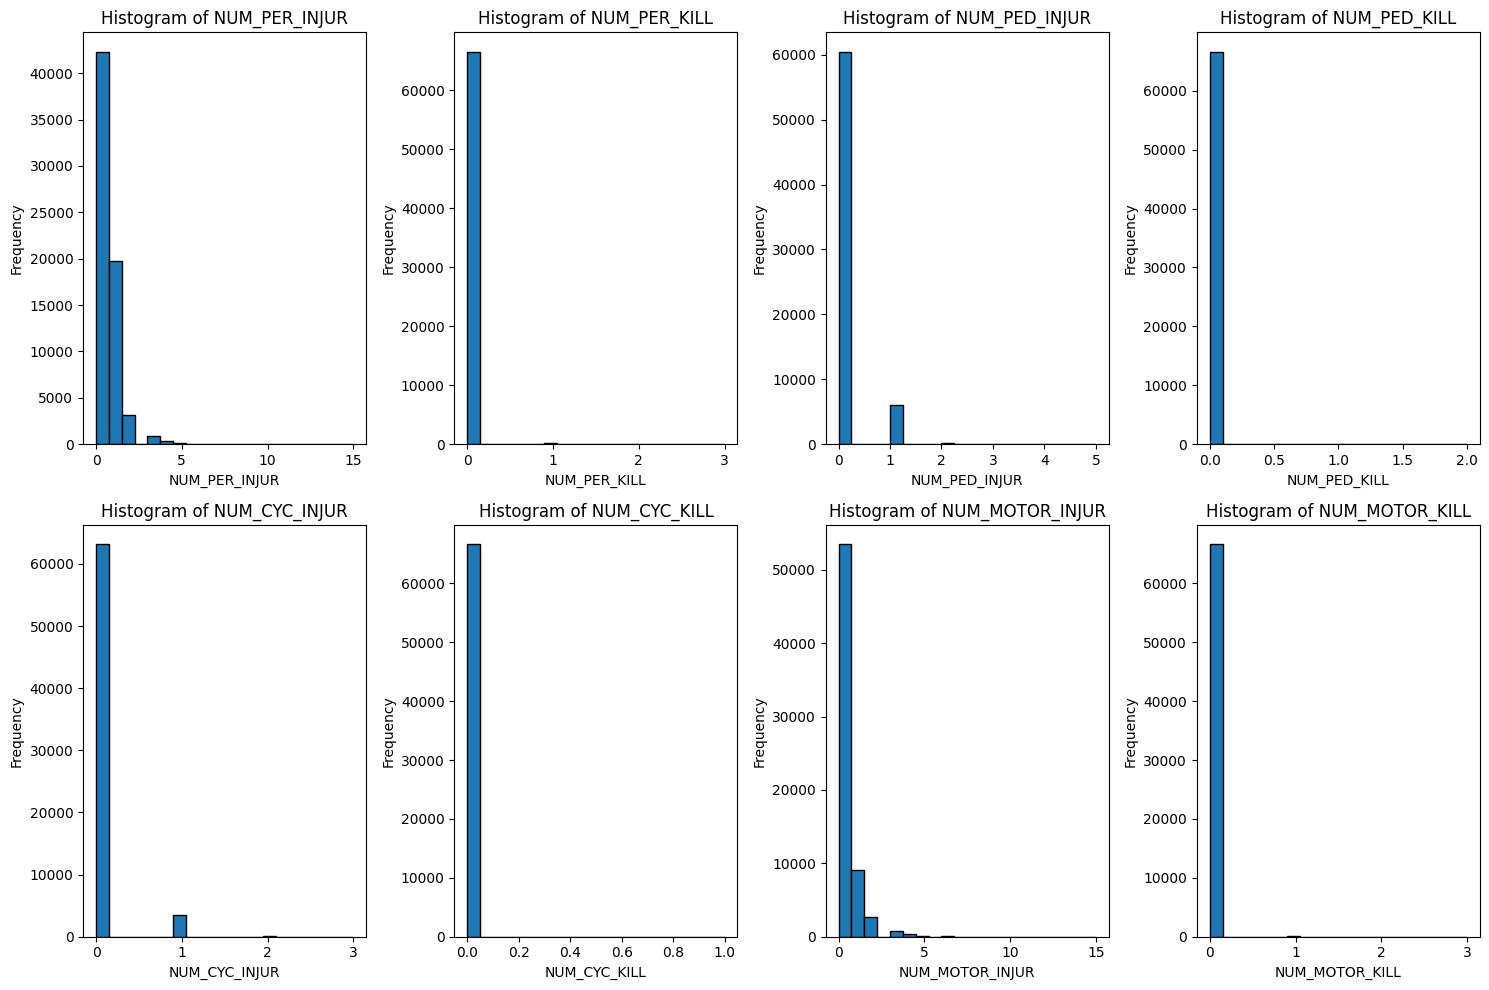

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# List of columns to plot
columns_to_plot = ["NUM_PER_INJUR", "NUM_PER_KILL", "NUM_PED_INJUR",
                   "NUM_PED_KILL", "NUM_CYC_INJUR", "NUM_CYC_KILL",
                   "NUM_MOTOR_INJUR", "NUM_MOTOR_KILL"]

# Create a histogram for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    plt.hist(pdf[column], bins=20, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Create summary table by time in a day in PySpark
summary_table = df.groupBy(hour('CRASH TIME').alias('CRASH HOUR')).agg(
    sum(col("NUM_PER_INJUR")).alias("SUM_NUM_PER_INJUR"),
    sum(col("NUM_PER_KILL")).alias("SUM_NUM_PER_KILL"),
    sum(col("NUM_PED_INJUR")).alias("SUM_NUM_PED_INJUR"),
    sum(col("NUM_PED_KILL")).alias("SUM_NUM_PED_KILL"),
    sum(col("NUM_MOTOR_INJUR")).alias("SUM_NUM_MOTOR_INJUR"),
    sum(col("NUM_MOTOR_KILL")).alias("SUM_NUM_MOTOR_KILL"),
    sum(col("NUM_CYC_INJUR")).alias("SUM_NUM_CYC_INJUR"),
    sum(col("NUM_CYC_KILL")).alias("SUM_NUM_CYC_KILL")
).orderBy('CRASH HOUR')

# Show the summary table
summary_table.show()

+----------+-----------------+----------------+-----------------+----------------+-------------------+------------------+-----------------+----------------+
|CRASH HOUR|SUM_NUM_PER_INJUR|SUM_NUM_PER_KILL|SUM_NUM_PED_INJUR|SUM_NUM_PED_KILL|SUM_NUM_MOTOR_INJUR|SUM_NUM_MOTOR_KILL|SUM_NUM_CYC_INJUR|SUM_NUM_CYC_KILL|
+----------+-----------------+----------------+-----------------+----------------+-------------------+------------------+-----------------+----------------+
|         0|             1224|               2|              193|               0|                839|                 2|              110|               0|
|         1|              657|               5|               65|               2|                516|                 3|               54|               0|
|         2|              519|               7|               48|               4|                416|                 2|               41|               0|
|         3|              536|               2|           

In [ ]:
df.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- STREET_ON: string (nullable = true)
 |-- STREET_CROSS: string (nullable = true)
 |-- STREET_OFF: string (nullable = true)
 |-- NUM_PER_INJUR: integer (nullable = false)
 |-- NUM_PER_KILL: integer (nullable = false)
 |-- NUM_PED_INJUR: integer (nullable = true)
 |-- NUM_PED_KILL: integer (nullable = true)
 |-- NUM_CYC_INJUR: integer (nullable = true)
 |-- NUM_CYC_KILL: integer (nullable = true)
 |-- NUM_MOTOR_INJUR: integer (nullable = true)
 |-- NUM_MOTOR_KILL: integer (nullable = true)
 |-- VEH_FACTOR_1: string (nullable = true)
 |-- VEH_FACTOR_2: string (nullable = true)
 |-- VEH_FACTOR_3: string (nullable = true)
 |-- VEH_FACTOR_4: string (nullable = true)
 |-- VEH_FACTOR_5: string (nullable =

In [ ]:
#creatiing total casualties feature
df = df.withColumn('TOTALCAL', df['NUM_PED_INJUR'] + df['NUM_PER_KILL']+df['NUM_CYC_KILL']+df['NUM_MOTOR_KILL'])

In [ ]:
# List of categorical columns for label encoding
categorical_columns = ['BOROUGH','VEH_FACTOR_1', 'VEH_FACTOR_2', 'VEH_FACTOR_3', 'VEH_FACTOR_4', 'VEH_FACTOR_5',
                       'VEH_TYPE_1', 'VEH_TYPE_2', 'VEH_TYPE_3', 'VEH_TYPE_4', 'VEH_TYPE_5']

# Initialize StringIndexer list
indexers = [StringIndexer(inputCol=column, outputCol=column + "_Index", handleInvalid='keep') for column in categorical_columns]

# Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and Transform
df_encoded = pipeline.fit(df).transform(df)

# Show transformed DataFrame
df_encoded.show()

# Optionally, you can select only the encoded and numeric columns to reduce DataFrame size
selected_columns = [c for c in df.columns if c not in categorical_columns] + [c + "_Index" for c in categorical_columns]
df_final = df_encoded.select(selected_columns)

# Show final DataFrame
df_final.show()

+----------+----------+---------+--------+---------+----------+--------------------+-------------------+--------------------+--------------------+-------------+------------+-------------+------------+-------------+------------+---------------+--------------+--------------------+--------------------+------------+------------+------------+------------+--------------------+--------------------+----------+----------+----------+---------+--------+------------+--------+-------------+------------------+------------------+------------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+
|CRASH DATE|CRASH TIME|  BOROUGH|ZIP_CODE| LATITUDE| LONGITUDE|            LOCATION|          STREET_ON|        STREET_CROSS|          STREET_OFF|NUM_PER_INJUR|NUM_PER_KILL|NUM_PED_INJUR|NUM_PED_KILL|NUM_CYC_INJUR|NUM_CYC_KILL|NUM_MOTOR_INJUR|NUM_MOTOR_KILL|        VEH_FACTOR_1|        VEH_FACTOR_2|VEH_FACTOR_3|VEH_FACTOR_4|VEH_FACTOR_

In [ ]:
df_final.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- STREET_ON: string (nullable = true)
 |-- STREET_CROSS: string (nullable = true)
 |-- STREET_OFF: string (nullable = true)
 |-- NUM_PER_INJUR: integer (nullable = false)
 |-- NUM_PER_KILL: integer (nullable = false)
 |-- NUM_PED_INJUR: integer (nullable = true)
 |-- NUM_PED_KILL: integer (nullable = true)
 |-- NUM_CYC_INJUR: integer (nullable = true)
 |-- NUM_CYC_KILL: integer (nullable = true)
 |-- NUM_MOTOR_INJUR: integer (nullable = true)
 |-- NUM_MOTOR_KILL: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- DATE_YEAR: integer (nullable = true)
 |-- DATE_MTH: integer (nullable = true)
 |-- TIME_O: string (nullable = true)
 |-- TOTALCAL: integer (nullable = true)
 |-- BOROUGH_Index: double (nullable = false)

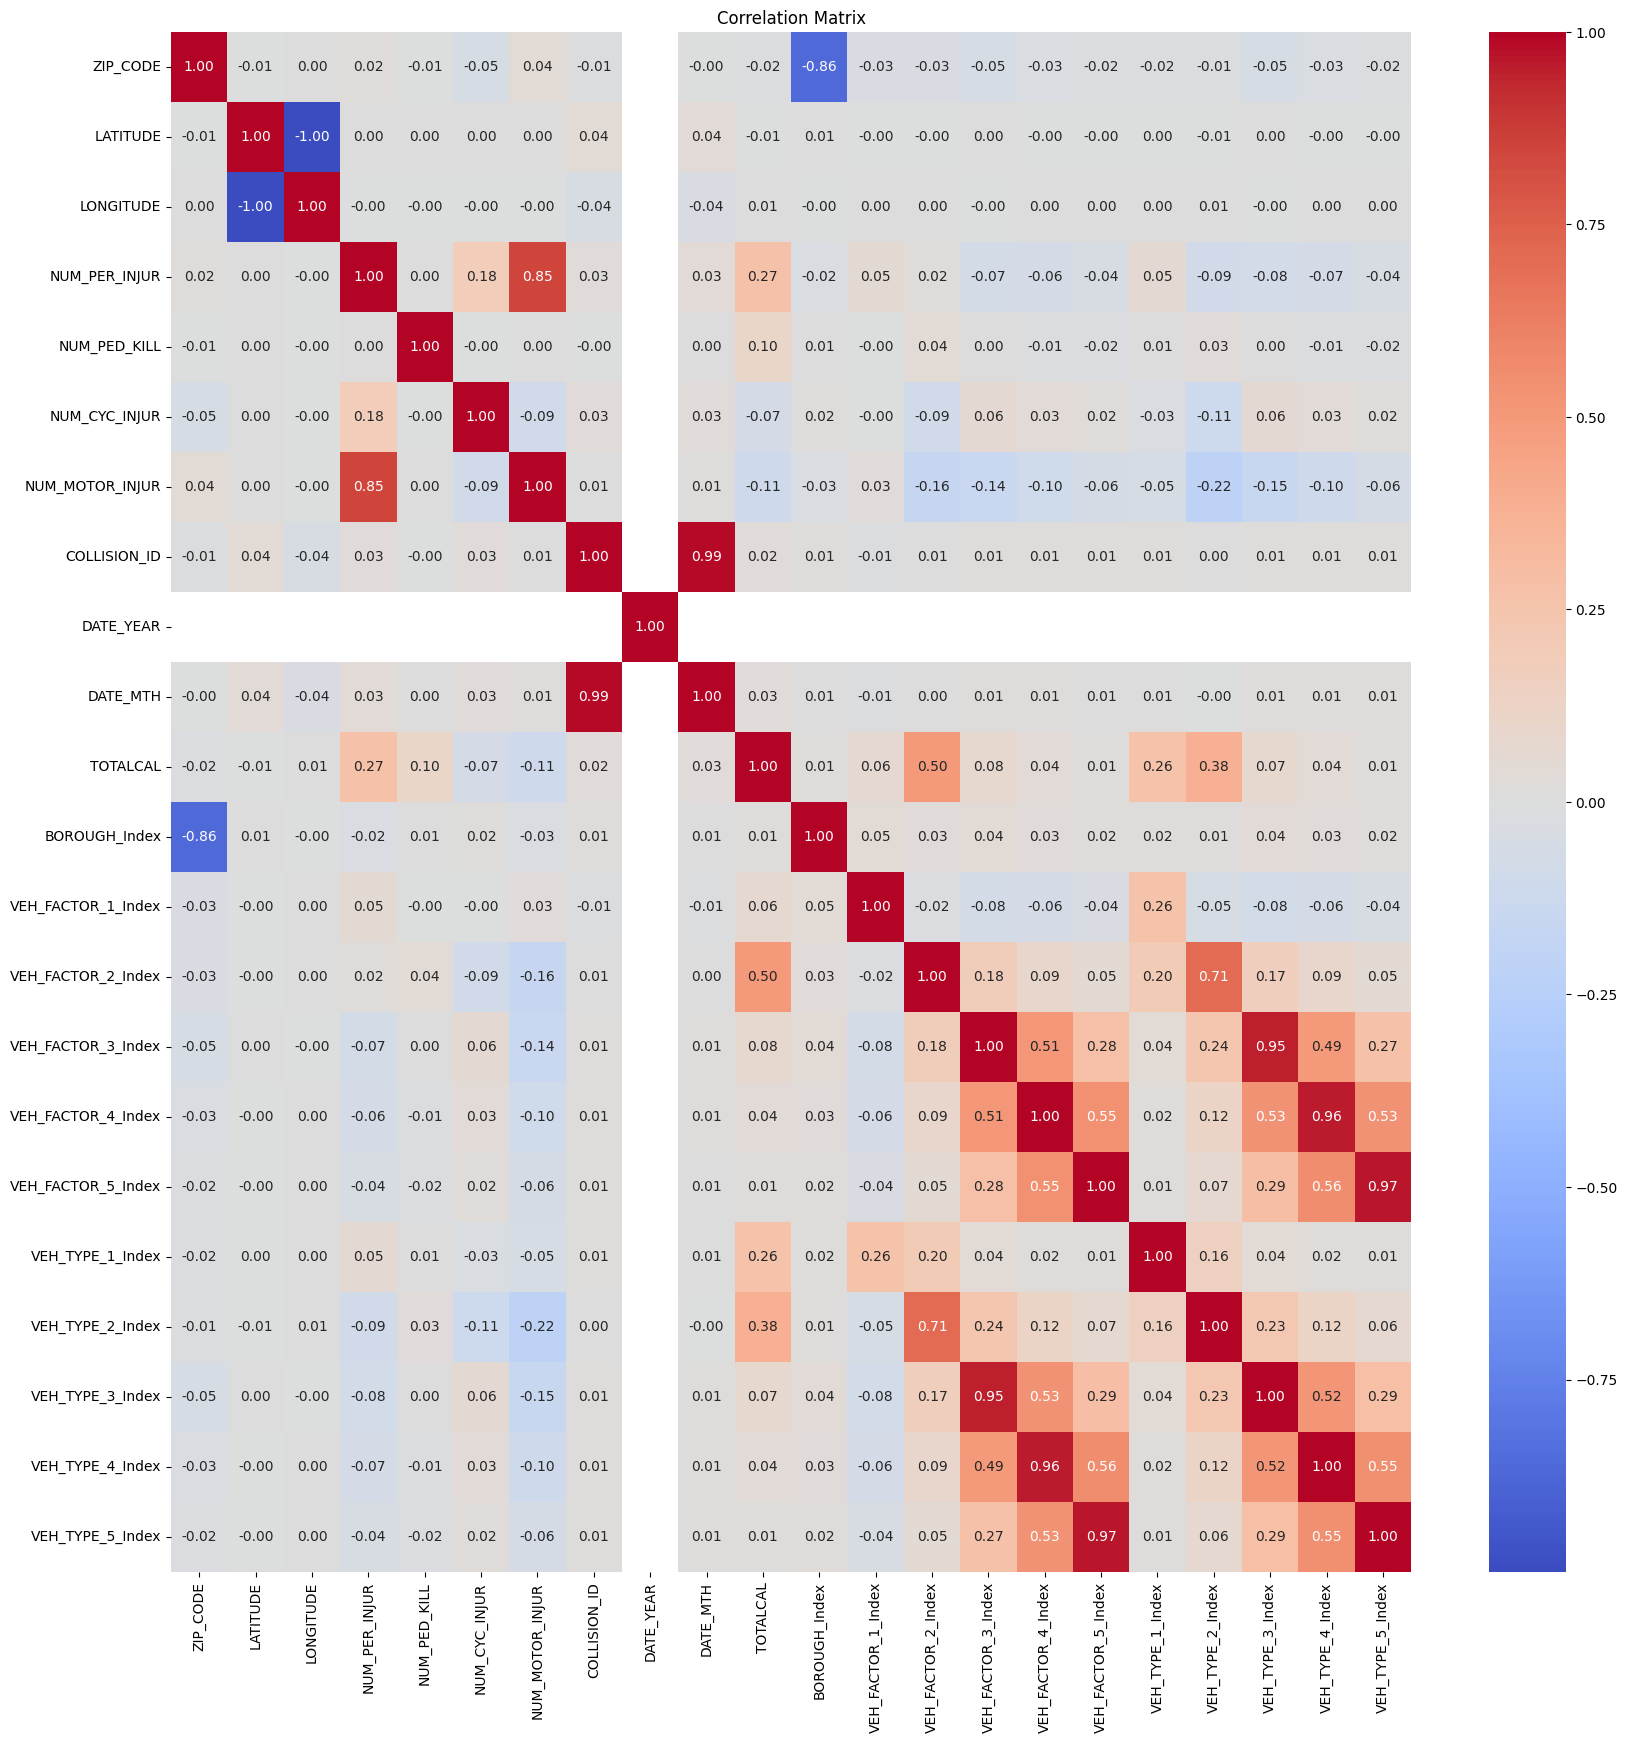

In [ ]:
# Now also exclude the specified columns
excluded_columns = ['CRASH TIME','CRASH DATE', 'LOCATION', 'STREET_ON', 'STREET_CROSS', 'STREET_OFF', 'TIME_O',
    'NUM_CYC_KILL', 'NUM_MOTOR_KILL', 'NUM_PER_KILL', 'NUM_PED_INJUR'
]
feature_columns = [col for col in df_final.columns if col not in excluded_columns and col != 'TOTAL_CASUALTIES']  # Replace 'TOTAL_CASUALTIES' with your target variable if it's different

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
df_vector = assembler.transform(df_final).select('TOTALCAL', 'features')  # Replace 'TOTAL_CASUALTIES' with your target variable if it's different

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Convert to Pandas DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix, columns=feature_columns, index=feature_columns)

# Plotting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**Linear Regression Model**

In [ ]:
# Assuming you want to predict NUM_PER_INJUR based on some other features
# Selecting features for the model
feature_columns = ['ZIP_CODE', 'LATITUDE', 'LONGITUDE', 'NUM_PER_INJUR', 'NUM_CYC_INJUR', 'NUM_MOTOR_INJUR', 'BOROUGH_Index', 'DATE_MTH','VEH_TYPE_1_Index']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transforming the DataFrame
output = assembler.transform(df_final)

# Selecting the features and the label
finalized_data = output.select("features", "TOTALCAL")

# Splitting the data into train and test sets
train_data, test_data = finalized_data.randomSplit([0.7, 0.3])

# Building the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='TOTALCAL')

# Fitting the model on train data
lr_model = lr.fit(train_data)

# Predicting on test data
predictions = lr_model.transform(test_data)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="TOTALCAL", predictionCol="prediction", metricName="rmse")

# Calculating RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Printing coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Root Mean Squared Error (RMSE) on test data = 0.16989676817632207
Coefficients: [2.2763394815215483e-06,-0.0075354504720054425,-0.004097785449252551,0.7749402337639184,-0.777945079668024,-0.7724007735065553,0.003939398134398555,-7.832924383244801e-05,0.0006120889248588278]
Intercept: -0.02541314684625601


In [ ]:
r2_evaluator = RegressionEvaluator(labelCol="TOTALCAL", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

R-squared on test data = 0.7221974300776506


****Classification models****

In [ ]:
# Create a new column 'severity' with conditions based on 'NUM_PER_INJUR' and 'NUM_PER_KILL'
df_final = df_final.withColumn(
    'Severity',
    when(col('NUM_PER_KILL') > 0, 'Fatal')
    .when((col('NUM_PER_KILL') == 0) & (col('NUM_PER_INJUR') > 0),'Injury')
    .otherwise('No Injury')
)
# Show some of the data to verify the new column
df_final.select('NUM_PER_KILL','NUM_PER_INJUR','Severity').show()

+------------+-------------+---------+
|NUM_PER_KILL|NUM_PER_INJUR| Severity|
+------------+-------------+---------+
|           0|            1|   Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            1|   Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            1|   Injury|
|           0|            1|   Injury|
|           0|            0|No Injury|
|           0|            1|   Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
|           0|            0|No Injury|
+------------+-------------+---------+
only showing top 20 rows



In [ ]:
df_final.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- STREET_ON: string (nullable = true)
 |-- STREET_CROSS: string (nullable = true)
 |-- STREET_OFF: string (nullable = true)
 |-- NUM_PER_INJUR: integer (nullable = false)
 |-- NUM_PER_KILL: integer (nullable = false)
 |-- NUM_PED_INJUR: integer (nullable = true)
 |-- NUM_PED_KILL: integer (nullable = true)
 |-- NUM_CYC_INJUR: integer (nullable = true)
 |-- NUM_CYC_KILL: integer (nullable = true)
 |-- NUM_MOTOR_INJUR: integer (nullable = true)
 |-- NUM_MOTOR_KILL: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- DATE_YEAR: integer (nullable = true)
 |-- DATE_MTH: integer (nullable = true)
 |-- TIME_O: string (nullable = true)
 |-- TOTALCAL: integer (nullable = true)
 |-- BOROUGH_Index: double (nullable = false)

**Feature importances for classification**

In [ ]:
# List of feature columns 
feature_columns = ['ZIP_CODE', 'LATITUDE', 'LONGITUDE', 'NUM_PER_INJUR', 'NUM_CYC_INJUR', 'NUM_MOTOR_INJUR', 'BOROUGH_Index', 'DATE_MTH','VEH_TYPE_1_Index']

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Convert the 'Severity' column to a numeric form using StringIndexer
severityIndexer = StringIndexer(inputCol="Severity", outputCol="label")

# Define a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10, maxBins=265)

# Define the pipeline with the correct stages
pipeline = Pipeline(stages=[assembler, severityIndexer, rf])

# Fit the pipeline to the DataFrame
pipelineModel = pipeline.fit(df_final)

# Retrieve the Random Forest model from the pipeline
rfModel = pipelineModel.stages[-1]

# Get feature importances
importances = rfModel.featureImportances

# Match feature importances with column names
importance_dict = dict()
for i, importance in enumerate(importances):
    importance_dict[feature_columns[i]] = importance

# Sort features by their importance
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted features by importance
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


NUM_PER_INJUR: 0.7319626972569658
NUM_MOTOR_INJUR: 0.20742585848147574
NUM_CYC_INJUR: 0.04562414744248846
VEH_TYPE_1_Index: 0.013039709163833898
DATE_MTH: 0.0008087458544913089
BOROUGH_Index: 0.00038194262295299195
LATITUDE: 0.000371792160577096
LONGITUDE: 0.0003110404193085863
ZIP_CODE: 7.406659790617209e-05


**Prediction of severity using random forest**

In [ ]:
# Split the data into training and test sets
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=12345)

# List of features to use based on the feature importances
feature_columns = [
    #'NUM_PER_INJUR', 'NUM_MOTOR_INJUR', 'NUM_CYC_INJUR',
    'VEH_TYPE_1_Index', 'ZIP_CODE', 'LONGITUDE', 'LATITUDE',
    'BOROUGH_Index', 'DATE_MTH'
]

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Convert the 'Severity' column to a numeric form using StringIndexer
severityIndexer = StringIndexer(inputCol="Severity", outputCol="label")

# Define a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20, maxDepth=5,maxBins=265)

# Define the pipeline with the correct stages
pipeline = Pipeline(stages=[assembler, severityIndexer, rf])

# Fit the pipeline to the training DataFrame
pipelineModel = pipeline.fit(train_df)

# Transform the test data to make predictions
predictions = pipelineModel.transform(test_df)

# Select example rows to display predictions
predictions.select('label', 'prediction', 'probability').show()

# Evaluate the model's performance on the test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.62179370214346...|
|  1.0|       0.0|[0.69179566265433...|
|  0.0|       0.0|[0.69101256365907...|
|  0.0|       0.0|[0.69179566265433...|
|  1.0|       0.0|[0.66400377001593...|
|  1.0|       0.0|[0.69101256365907...|
|  0.0|       0.0|[0.67318461200499...|
|  0.0|       0.0|[0.69179566265433...|
|  0.0|       0.0|[0.69179566265433...|
|  1.0|       0.0|[0.69179566265433...|
|  1.0|       0.0|[0.69179566265433...|
|  0.0|       0.0|[0.69641543677395...|
|  1.0|       0.0|[0.69563233777869...|
|  1.0|       0.0|[0.69179566265433...|
|  0.0|       0.0|[0.69563233777869...|
|  1.0|       0.0|[0.67503083889098...|
|  1.0|       0.0|[0.69641543677395...|
|  0.0|       0.0|[0.69641543677395...|
|  1.0|       0.0|[0.69179566265433...|
|  0.0|       0.0|[0.67446126131257...|
+-----+----------+--------------------+
only showing top 20 rows

Test Accuracy:

**Model Evaluation**

In [ ]:

# Evaluate the model on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate weighted precision
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(f"Weighted Precision: {weightedPrecision}")

# Calculate weighted recall
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(f"Weighted Recall: {weightedRecall}")

# Calculate F1 Score
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"F1 Score: {f1}")

# If needed, calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")


Weighted Precision: 0.7037130618485571
Weighted Recall: 0.6619353884822946
F1 Score: 0.5707174837272877
Accuracy: 0.6619353884822947


**Decision Trees model**

In [ ]:
# Define a Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label",maxBins=265)

# Define the pipeline with the correct stages
pipeline_dt = Pipeline(stages=[assembler, severityIndexer, dt])

# Fit the pipeline to the training DataFrame
pipelineModel_dt = pipeline_dt.fit(train_df)

# Transform the test data to make predictions
predictions_dt = pipelineModel_dt.transform(test_df)

# Select example rows to display predictions
predictions_dt.select('label', 'prediction', 'probability').show()

# Evaluate the model's performance on the test data
evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print(f"Test Accuracy: {accuracy_dt}")

# Evaluate other metrics
weightedPrecision_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "weightedPrecision"})
weightedRecall_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "weightedRecall"})
f1_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "f1"})
print(f"Weighted Precision: {weightedPrecision_dt}")
print(f"Weighted Recall: {weightedRecall_dt}")
print(f"F1 Score: {f1_dt}")


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.77777777777777...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
|  1.0|       0.0|[0.66118733281560...|
|  0.0|       0.0|[0.66118733281560...|
+-----+----------+--------------------+
only showing top 20 rows

Test Accuracy:

**Multiclass Logistic Regression**

In [ ]:
# Define a Logistic Regression Classifier
lr = LogisticRegression(featuresCol="features", labelCol="label", family="multinomial")

# Define the pipeline with the correct stages
pipeline_lr = Pipeline(stages=[assembler, severityIndexer, lr])

# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Evaluator for cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Cross-validator
crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Adjust the number of folds as needed

# Fit the model
cvModel = crossval.fit(train_df)

Test Accuracy: 0.6387964811118504
Best model's regParam: 0.1
Best model's elasticNetParam: 0.0


**Model evaluation**

In [ ]:
# Initialize evaluators for different metrics
accuracyEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precisionEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recallEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1Evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate metrics
accuracy = accuracyEvaluator.evaluate(predictions)
precision = precisionEvaluator.evaluate(predictions)
recall = recallEvaluator.evaluate(predictions)
f1 = f1Evaluator.evaluate(predictions)

# Print the metrics
print(f"Test Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")

Test Accuracy: 0.6387964811118504
Weighted Precision: 0.6770378120264597
Weighted Recall: 0.6387964811118503
